In [11]:
import numpy as np
from orphics import maps, cosmology,io,stats
from scipy import optimize
import szar
from szar import foregrounds
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


In [4]:
class Combiner():
    def __init__(self, ells, spectra_cross: dict = {}, spectra_auto: dict = {}):
        '''
        ells: bins in l space
        spectra_cross: cross of field fi with g, just use fi as the name 
        spectra_auto: fi, fj crosses
        '''
        self.nbins=len(ells)
        spectra_list=list(spectra_cross.keys())
        self.Nfields = len(spectra_list)
        self.spectra_cross = np.zeros((self.nbins, self.Nfields))
        self.spectra_auto = np.zeros((self.nbins, self.Nfields, self.Nfields))
        
        for i, name in enumerate(spectra_list):
            self.spectra_cross[:, i] = spectra_cross[name]
            for j, name2 in enumerate(spectra_list):
                try:
                    self.spectra_auto[:, i, j] = spectra_auto[name+name2]
                except:
                    self.spectra_auto[:,i,j]= spectra_auto[name2+name]
    
    def combine(self, a):
        cross = np.einsum('...j, ...j -> ...', a, self.spectra_cross)
        auto = np.einsum('...i, ...ij, ...j -> ...', a, self.spectra_auto, a)
        return cross, auto
    
class Forecaster():
    def __init__(self, fsky, ells, names : list = ['k', 'g'], spectra: dict ={}, use_as_data: list = ['kg', 'gg', 'kk']):
        '''
        fsky: fraction of sky
        ells: bins in l space, centers
        spectra:dict in which key corresponds to the name of C_ell, and values are C_ell array
        names: put field to be cleaned first, then the cross correlated one 
        use_as_data: spectra used in practice, e.g. kk, gg or kk, gg, kg 
        '''
        self.names = names
        self.k = names[0]
        self.g = names[1]
        self.Nfields = len(names)
        self.nbins = len(ells)
        self.Nmodes = self.get_Nmodes(ells, fsky) 
        self.fsky = fsky
        self.list_spectra = use_as_data #list(spectra.keys()) 
        self.Nspectra = len(self.list_spectra)
        #self.used = use_as_data
        self.spectra = spectra
        
    def get_Nmodes(self, ells, fsky):
        deltal = ells[1]-ells[0] #ells[1:]-ells[:-1] 
        result = (2*ells*deltal*fsky)
        return result
    
    def get_spectra_element(self, X, Y): 
        try:
            result=self.spectra[X+Y]
        except:
            result=self.spectra[Y+X]
        return result
    
    def get_gaussian_cov(self, X, Y, W, Z):
        result = 1/self.Nmodes*(self.get_spectra_element(X, W)*self.get_spectra_element(Y, Z)+self.get_spectra_element(X, Z)*self.get_spectra_element(Y, W))
        return result
    
    def get_cov(self, X, Y, W, Z):
        return self.get_gaussian_cov(X, Y, W, Z)
    
    def prepare_cov_for_error(self, separator = ','):
        self.cov = np.zeros((self.nbins, self.Nspectra, self.Nspectra))
        self.cov_dict = {}
        for a in self.list_spectra: 
            for b in self.list_spectra:
                X, Y = list(a)
                W, Z = list(b)
                i = self.list_spectra.index(a)
                j = self.list_spectra.index(b) 
                covariance = self.get_cov(X, Y, W, Z) 
                self.cov[:, i, j] = covariance 
                self.cov_dict[a+separator+b]= covariance
        self.invcov = np.linalg.inv(self.cov)
        return 0
    
    def make_fisher_and_err_bars(self, alphas, der_spectra_alpha):
        '''
        a: vector for the combination
        e.g., Ckk = a.T Ckiki a, Ckg = a.T Ckig 
        '''
        Npars = len(alphas)
        assert(der_spectra_alpha.shape[0] == self.nbins) 
        assert(der_spectra_alpha.shape[1] == self.Nspectra) 
        assert(der_spectra_alpha.shape[2] == Npars)
        
        fisher_per_mode = np.einsum('...ik, ...ij, ...jm -> ...km',der_spectra_alpha, np.nan_to_num(self.invcov), der_spectra_alpha)
        self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)
        fisher_integrated = np.sum(fisher_per_mode, axis = 0) 
        self.fisher = fisher_integrated 
        self.error_non_marginalized = np.diag(self.fisher)**-0.5 
        self.error_marginalized = np.linalg.inv(self.fisher)**0.5 
        return self.error_marginalized
    

In [6]:
def make_multiple_plots(l, spectra_list = [], labels = [], colors = [], ls = [],title = '', ylabel = '$C_l$', xlabel = '$l$', yscale = 'log', xscale ='linear'):
    plt.title(title)
    for i, c in enumerate(spectra_list):
        plt.semilogy(l, c, color = colors[i], ls = ls[i], label = labels[i]) 
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.yscale(yscale)
    plt.xscale(xscale)
    plt.legend(loc = 'best', fontsize = 15) 
    plt.show()
    plt.close()

In [7]:
bias = 2.
zmin, zmax = 0.2, 0.5
bias_cib = 1.
zmin_cib, zmax_cib = 4, 500
fsky = 1.

In [19]:
#load galaxy and cib
lc=cosmology.LimberCosmology(lmax=2000,pickling=True)
lc.addStepNz("g", zmin, zmax, bias = bias) 
lc.addStepNz("cib", zmin_cib, zmax_cib, bias = bias_cib)

Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_2000_20210126.pkl
Loaded cached Cls from  output/clphi_low_acc_False_2000_20210126.txt
initializing power...
Initializing CMB window..
('Initializing galaxy window for ', 'g', ' ...')
('Initializing galaxy window for ', 'cib', ' ...')


In [20]:
ellrange = np.logspace(np.log(2), np.log(20), 10) #np.log(1,2000,100)
lc.generateCls(ellrange)
clkk = lc.getCl("cmb","cmb") 
clkg0 = lc.getCl("cmb","g") 
clgg0 = lc.getCl("g","g") 
clcibcib = lc.getCl("cib","cib") #what is the difference between this cib and the one in [26] at 145Ghz
clcibg0 = lc.getCl("cib","g") 
clcibk = lc.getCl("cib","cmb")
clkg = clkg0*bias 
clgg = clgg0*bias**2 
clcibg = clcibg0*bias

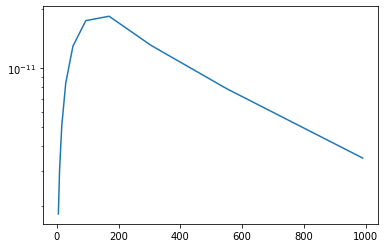

In [16]:
plt.semilogy(ellrange,clcibcib)

In [22]:
nu0 = 145
clcibcib145 = foregrounds.power_cibc(ellrange, nu1 = nu0)+foregrounds.power_cibp(ellrange, nu1 = nu0)
kappa_cib_corrcoeff = foregrounds.kappa_cib_corrcoeff(ellrange) 
clcib145k = np.sqrt(clcibcib145*clkk)*kappa_cib_corrcoeff

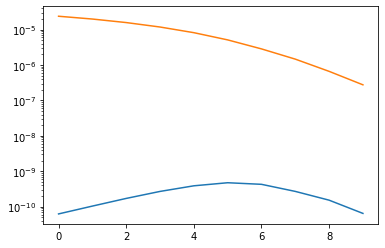

In [23]:
plt.semilogy(clcibk)
plt.semilogy(clcib145k)

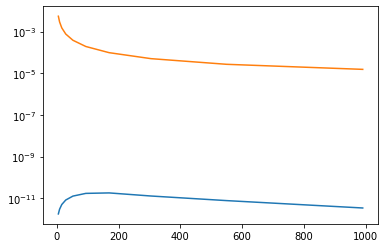

In [17]:
plt.semilogy(ellrange,clcibcib)
plt.semilogy(ellrange,clcibcib145)
